In [1]:
%matplotlib inline
import os
import torch
import sys
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.nn import MSELoss, Sequential, Linear, Sigmoid, Tanh, L1Loss, Module, Parameter
from torch.autograd import Variable
# Ignore warnings
import warnings
from torch import nn
import torch.nn.functional as F

try:
    from tensorboardX import SummaryWriter
except ImportError:
    raise RuntimeError("No tensorboardX package is found. Please install with the command: \npip install tensorboardX")

from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss




Image name: 109.jpeg
Landmarks shape: (68, 2)
First 4 Landmarks: [[ 7. 41.]
 [ 8. 51.]
 [10. 60.]
 [13. 70.]]


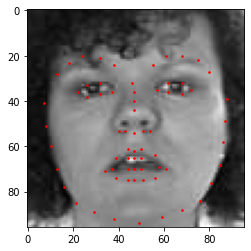

In [2]:
warnings.filterwarnings("ignore")

landmarks_frame = pd.read_csv('dataset/train/face_landmarks.csv')

n = 100
img_name = landmarks_frame.values[n, 0]
landmarks = landmarks_frame.values[n, 1:].astype('float')
landmarks = landmarks.reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image, cmap='gray')
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='red', cmap='rgb')
    plt.pause(0.001)  

plt.figure()
show_landmarks(io.imread(os.path.join('dataset/train/', img_name)),
               landmarks)
plt.show()

In [3]:
def show_landmarks_batch(sample_batch, y_pred=None):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batch
    batch_size = len(images_batch)
    im_size = images_batch.size(2)

    grid = utils.make_grid(images_batch)
    print(images_batch.numpy().shape)
    plt.imshow(grid.numpy().transpose(1,0,2).reshape(im_size, -1), cmap="gray")

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size,
                    landmarks_batch[i, :, 1].numpy(),
                    s=10, marker='.', c='r', label='Real')

    if type(y_pred) != type(None):
        for i in range(batch_size):
            plt.scatter(y_pred[i, :, 0] + i * im_size,
                        y_pred[i, :, 1],
                        s=10, marker='.', c='b',  label='Prediction')
        plt.title('Batch from dataloader')
    plt.legend()

In [4]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:].values.astype('float')
        landmarks = landmarks.reshape(-1, 2)
        sample = image, landmarks

        if self.transform:
            sample = self.transform(sample)
        image, landmarks = sample
        
        sample = image.expand(3,96, 96) , landmarks
        return sample

In [5]:
class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return image, landmarks




class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample
        return torch.from_numpy(image).type(torch.float), torch.from_numpy(landmarks).type(torch.float)

In [6]:
train_dataset = FaceLandmarksDataset(csv_file='dataset/train/face_landmarks.csv',
                                     root_dir='dataset/train',
                                     transform=ToTensor())

test_dataset = FaceLandmarksDataset(csv_file='dataset/test/face_landmarks.csv',
                                     root_dir='dataset/test',
                                     transform=ToTensor())

In [7]:
def get_data_loaders(train_batch_size=64, val_batch_size=64):

    train_loader = DataLoader(
        train_dataset, batch_size=train_batch_size, shuffle=True
    )

    test_loader = DataLoader(
        test_dataset, batch_size=val_batch_size, shuffle=False
    )

    return train_loader, test_loader

In [8]:
from torchvision import models
model = models.resnet18(pretrained=True)

# Disable grad for all conv layers
for param in model.parameters():
    param.require_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, 68 * 2)
model.fc1 = torch.nn.Linear(68 * 2, 68 * 2)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/nikola/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [9]:
network = model
train_dataloader, test_dataloader = get_data_loaders()
writer = SummaryWriter(filename_suffix='first', logdir="out_logs")

device = "gpu"

if torch.cuda.is_available():
    device = "cuda"
criterion = MSELoss()
optim = torch.optim.Adam
learning_rate = 0.01
max_epochs = 100

optimizer = optim(network.parameters(), lr=learning_rate)

trainer = create_supervised_trainer(network, optimizer, criterion, device=device)
evaluator = create_supervised_evaluator(
    network, metrics={"L2 loss": Loss(criterion), "L1 loss": Loss(L1Loss())}, device=device
)

training_history = {'l1':[],'l2':[]}
validation_history = {'l1':[],'l2':[]}
last_epoch = []

In [10]:
@trainer.on(Events.ITERATION_COMPLETED(every=10))
def log_training_loss(engine):
    writer.add_scalar("training/loss", engine.state.output, engine.state.iteration)
    writer.flush()


@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    evaluator.run(train_dataloader)
    metrics = evaluator.state.metrics
    l2_train = metrics["L2 loss"]
    l1_train = metrics['L1 loss']
    last_epoch.append(0)
    training_history['l2'].append(l2_train)
    training_history['l1'].append(l1_train)
    writer.add_scalar("training/epoch_loss", l2_train, trainer.state.epoch)
    
    evaluator.run(test_dataloader)
    metrics = evaluator.state.metrics
    l2 = metrics["L2 loss"]
    l1 = metrics['L1 loss']
    validation_history['l2'].append(l2)
    validation_history['l1'].append(l1)
    
    writer.add_scalar("validation/epoch_loss", l2, trainer.state.epoch)
    writer.flush()
    
    sys.stdout.write("\rTraining/Validation Results - Epoch: {}  Avg MSE: {:.2f} / {:.2f} Avg MAE: {:.2f} / {:.2f}"
          .format(trainer.state.epoch, l2_train, l2, l1_train, l1))
   

In [11]:
train_dataloader, test_dataloader = get_data_loaders()

device = torch.device("cuda")# if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)#, weight_decay=0.001)

In [12]:
model.eval()

batch_size = 32

train_loss_history = []
test_loss_history  = []

for epoch in range(60):
  
    model.train()
    losses = []

    for i, (X, y) in enumerate(train_dataloader):
       
        X = X.to(device)
        y = y.to(device)
        model.zero_grad()
        y_pred = model.forward(X)
        train_loss = loss(y_pred.view(-1, 68, 2), y)
        losses.append(train_loss.item())
        train_loss.backward()
        optimizer.step()
  
        print("\rtrain mse: %.4f" % losses[-1], '\t\tepoch:', epoch+1, '\t\t(step: %i)' % i, end='')
    
    train_loss_history.append(np.mean(losses))
    model.eval()
    
    print("\rtrain mse: %.4f" % train_loss_history[-1], '\t\tepoch:', epoch+1)




    losses = []
    for i, (X, y) in enumerate(test_dataloader):


        X = X.to(device)
        y = y.to(device)
      
        y_pred = model.forward(X)
        test_loss = loss(y_pred.view(-1, 68, 2), y)
        losses.append(test_loss.item())
      
        print("\rtest mse: %.4f" % losses[-1], '\t\tepoch:', epoch+1, '\t\t(step: %i)' % i, end='')
    
    test_loss_history.append(np.mean(losses))
    print("\rtest mse: %.4f" % test_loss_history[-1], '\t\tepoch:', epoch+1)
    print()

train mse: 1152.5422 		epoch: 1		(step: 97)) 		(step: 27) 		(step: 73)
test mse: 129.1292 		epoch: 1 		(step: 24)

train mse: 32.6538 		epoch: 2 		(step: 97)
test mse: 21.7501 		epoch: 2 		(step: 24)

train mse: 14.4382 		epoch: 3 		(step: 97)
test mse: 22.1190 		epoch: 3 		(step: 24)

train mse: 14.2404 		epoch: 4 		(step: 97)
test mse: 15.7198 		epoch: 4 		(step: 24)

train mse: 13.9169 		epoch: 5		(step: 97))
test mse: 16.5615 		epoch: 5 		(step: 24)

train mse: 11.9704 		epoch: 6 		(step: 97)
test mse: 12.0385 		epoch: 6 		(step: 24)

train mse: 10.1398 		epoch: 7 		(step: 97)		(step: 7)
test mse: 13.7551 		epoch: 7 		(step: 24)

train mse: 8.7852 		epoch: 8 		(step: 97))
test mse: 11.4811 		epoch: 8 		(step: 24)

train mse: 8.2477 		epoch: 9 		(step: 97))
test mse: 8.8727 		epoch: 9 		(step: 24))

train mse: 6.4432 		epoch: 10 		(step: 97))
test mse: 6.8593 		epoch: 10 		(step: 24))

train mse: 5.2224 		epoch: 11 		(step: 97)11 		(step: 35)
test mse: 7.0292 		epoch: 11 		(step: 24

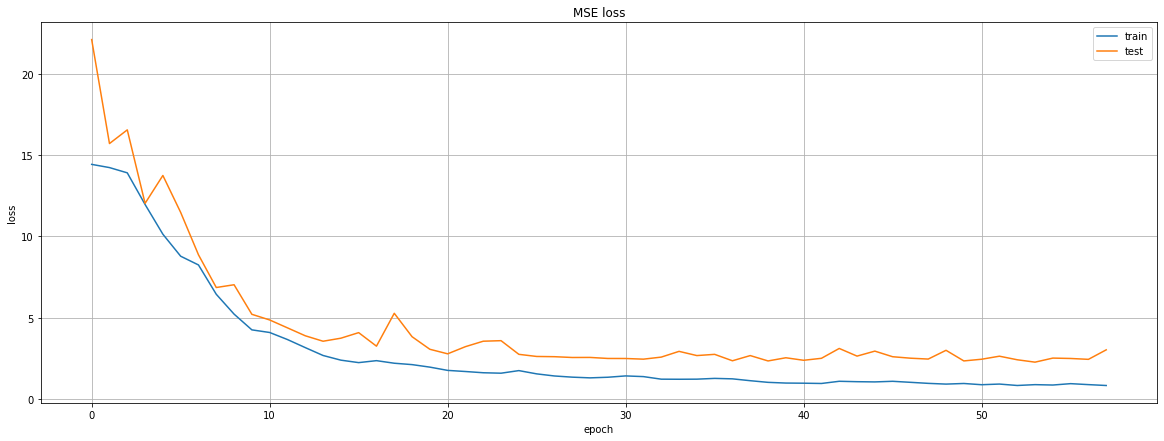

In [13]:
fig, ax = plt.subplots(1, figsize=(20,7))

ax.plot(train_loss_history[2:], label='train')
ax.plot(test_loss_history[2:],  label='test')

ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title('MSE loss')
ax.legend()
ax.grid()


In [14]:
_, test_dataloader = get_data_loaders(val_batch_size=2)

images_batch = next(iter(test_dataloader))
X, y = images_batch


X = X.to(device)
y = y.to(device)

y_pred = model(X)
y_pred = y_pred.data.cpu().numpy().reshape(-1, 68, 2)
show_landmarks_batch(images_batch, y_pred)


(2, 3, 96, 96)


ValueError: cannot reshape array of size 59400 into shape (96,newaxis)